# Interest Rate Prediction

### Setup and Loading the Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Load dataset
url = "https://fred.stlouisfed.org/series/FEDFUNDS"
data = pd.read_csv("FEDFUNDS.csv")

# Data inspection
print(data.head())
print(data.info())


         DATE  FEDFUNDS
0  1954-07-01      0.80
1  1954-08-01      1.22
2  1954-09-01      1.07
3  1954-10-01      0.85
4  1954-11-01      0.83
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      844 non-null    object 
 1   FEDFUNDS  844 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.3+ KB
None


### Data Preprocessing and Feature Engineering

In [27]:
# Data preprocessing
# Convert date to datetime format and filter for relevant data
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.set_index('DATE')

# Remove rows with missing values
data = data.dropna()

# Feature engineering
# Use lagged interest rates as features
data['Lag_1'] = data['FEDFUNDS'].shift(1)
data['Lag_2'] = data['FEDFUNDS'].shift(2)
data['Lag_3'] = data['FEDFUNDS'].shift(3)
data = data.dropna()

# Define input features (X) and target variable (y)
X = data[['Lag_1', 'Lag_2', 'Lag_3']]
y = data['FEDFUNDS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Standardization

In [4]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Building and Compiling the Initial Model

In [5]:
# Build the initial model
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

c:\Users\laura\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### TO DO: Train the model, evaluate performance, visualize results, and make modifications based on results (repeat)

RNN model w/ lstm


In [159]:
# Data preprocessing
data = pd.read_csv("FEDFUNDS.csv")

# normalize percentages to [0, 1]
data['FEDFUNDS'] = data['FEDFUNDS'] / 100

# combine into one dataframe
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.set_index('DATE')

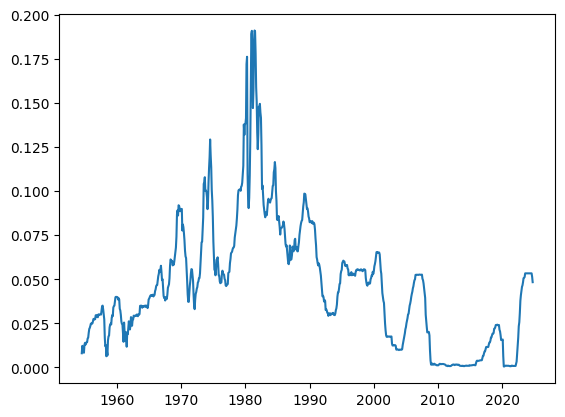

In [160]:
plt.plot(data)
plt.show()

In [161]:
def create_dataset(data, window=24):
    datanp = np.array(data)
    X, y = [], []
    for i in range(len(datanp) - window):
        X.append([x for x in datanp[i:i+window]])
        y.append(datanp[i+window])
    return np.array(X).astype('float32'), np.array(y).astype('float32')

window_size = 48
X, y = create_dataset(data, window_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(636, 48, 1) (636, 1)
(160, 48, 1) (160, 1)


In [162]:
print(X_train)

[[[0.0531]
  [0.0529]
  [0.0525]
  ...
  [0.1761]
  [0.1098]
  [0.0947]]

 [[0.0612]
  [0.0591]
  [0.0578]
  ...
  [0.0545]
  [0.0553]
  [0.0592]]

 [[0.1331]
  [0.1237]
  [0.1322]
  ...
  [0.079 ]
  [0.0792]
  [0.0799]]

 ...

 [[0.0461]
  [0.0468]
  [0.0469]
  ...
  [0.1281]
  [0.1585]
  [0.189 ]]

 [[0.0811]
  [0.0781]
  [0.0731]
  ...
  [0.0426]
  [0.0447]
  [0.0473]]

 [[0.0292]
  [0.03  ]
  [0.0298]
  ...
  [0.0553]
  [0.0576]
  [0.054 ]]]


In [168]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                  │ (None, 48, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [169]:
model.fit(X_train, y_train, epochs=40)

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0018 - mae: 0.0316
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.3959e-04 - mae: 0.0141
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.7648e-04 - mae: 0.0097
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.7578e-04 - mae: 0.0094
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.6574e-04 - mae: 0.0088
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.3951e-04 - mae: 0.0083
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.7415e-04 - mae: 0.0086
Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.3238e-04 - mae: 0.0078
Epoch 9/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.4607e-04 - mae: 0.0079
Epoch 10/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.7025e-04 - mae: 0.0088
Epoch 11/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 1.6842e-04 - mae: 0.0091
Epoch 12/40
 6/20 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.1057e-04 - mae: 

KeyboardInterrupt: 

In [165]:
model.predict(X)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


array([[0.01560148, 0.01484462],
       [0.01232737, 0.01165546],
       [0.0111708 , 0.01064605],
       ...,
       [0.05565216, 0.05511877],
       [0.05560445, 0.055084  ],
       [0.05529746, 0.05477458]], dtype=float32)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


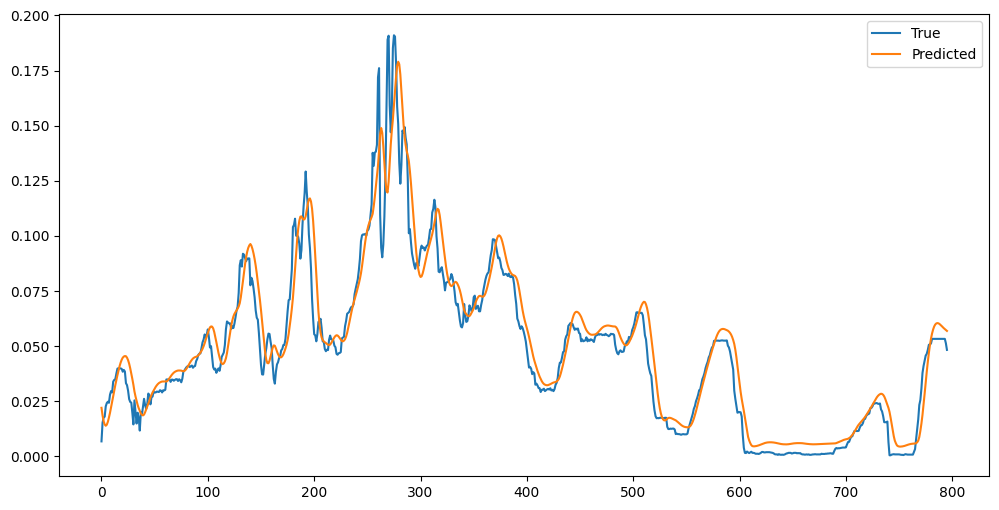

In [170]:
# plotting both the predictions and the test data

y_pred = model.predict(X)
plt.figure(figsize=(12, 6))
plt.plot(y, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


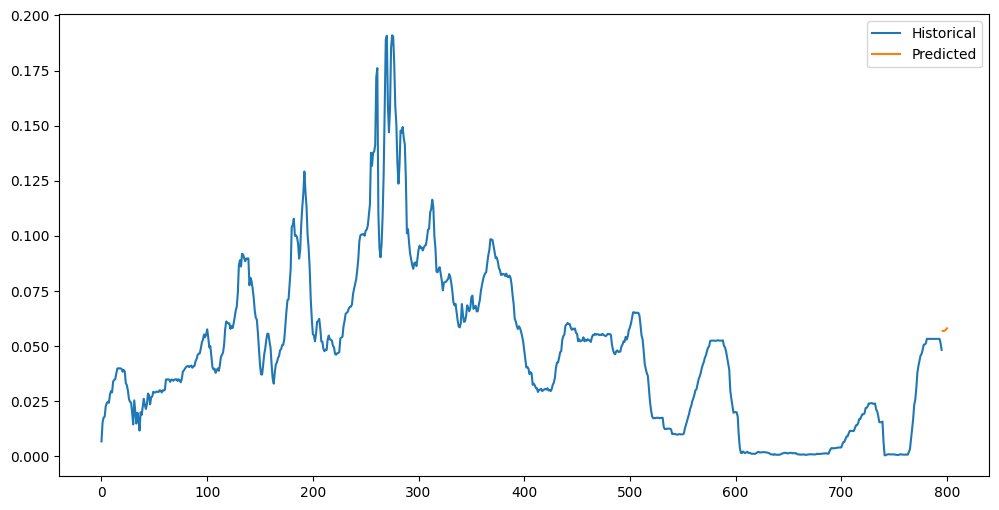

In [182]:
def predict_interest_rates(months=5):
    last_window = X[-1]
    predictions = []
    for i in range(months):
        prediction = model.predict(np.array([last_window]))
        predictions.append(prediction[0])
        last_window = np.append(last_window[1:], prediction, axis=0)
    return predictions

predictions = predict_interest_rates(5)

plt.figure(figsize=(12, 6))
plt.plot(y, label='Historical')
plt.plot(range(len(y), len(y) + len(predictions)), predictions, label='Predicted')
plt.legend()
plt.show()

In [177]:
data.tail()

,FEDFUNDS
DATE,
2024-06-01,0.0533
2024-07-01,0.0533
2024-08-01,0.0533
2024-09-01,0.0513
2024-10-01,0.0483
